## OUTLIER DETECTION DAY 2/OUTLIER DETECTION PART 3 EXERCISE ANSWERS ##
#### Exercise 1 ####
#### Task 1
##### Import the required packages including StandardScaler
##### Set the working directory to data directory
##### Print the working directory and the plot directory
#### Result:


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler  
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
# Set 'main_dir' to location of the project folder
from pathlib import Path 
home_dir = Path(".").resolve()
main_dir = home_dir.parent
print(main_dir)
data_dir = str(main_dir) + "/data"
print(data_dir)


/Users/swaroopnc/Downloads/SkillAnamoly2025
/Users/swaroopnc/Downloads/SkillAnamoly2025/data


#### Task 2
##### Read in `seismic-hazards.csv` to a new dataframe `hazard`.
##### Read the documentation to understand the variables https://archive.ics.uci.edu/ml/datasets/seismic-bumps#
##### Explore the dataset by printing its head, info and shape.
#### Result:


In [2]:
hazard = pd.read_csv(str(data_dir)+'/seismic-hazard.csv')
hazard.head()
hazard.shape
hazard.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2584 non-null   int64 
 1   seismic         2584 non-null   object
 2   seismoacoustic  2584 non-null   object
 3   shift           2584 non-null   object
 4   genergy         2584 non-null   int64 
 5   gpuls           2584 non-null   int64 
 6   gdenergy        2584 non-null   int64 
 7   gdpuls          2584 non-null   int64 
 8   ghazard         2584 non-null   object
 9   nbumps          2584 non-null   int64 
 10  nbumps2         2584 non-null   int64 
 11  nbumps3         2584 non-null   int64 
 12  nbumps4         2584 non-null   int64 
 13  nbumps5         2584 non-null   int64 
 14  nbumps6         2584 non-null   int64 
 15  nbumps7         2584 non-null   int64 
 16  nbumps89        2584 non-null   int64 
 17  energy          2584 non-null   int64 
 18  maxenerg

#### Task 3
##### Drop all the non-numerical and id columns - `['seismic','seismoacoustic','shift','ghazard','id']` 
##### Save this subset as `hazard_sub` and print its head.
#### Result:


In [3]:
hazard_sub = hazard.drop(['seismic','seismoacoustic','shift','ghazard','id'], axis = 1)
hazard_sub.head()
hazard_sub['class'].value_counts()


class
0    2414
1     170
Name: count, dtype: int64

#### Task 4
##### Define your features X = all columns except class, and target y = class.
##### Perform a stratified train/test split (30% test).
##### From the train‐split, isolate the “inliers” (class==0) into X_train_inliers.
##### Scale both X_train_inliers and the held‐out X_test with StandardScaler (fit on inliers only).`
#### Result:


In [4]:
X = hazard_sub.drop('class', axis=1)
y = hazard_sub['class']
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
# Inlier training set
X_train_inliers = X_train_full[y_train_full == 0]
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_inliers)
X_test_scaled  = scaler.transform(X_test)


#### Task 5
##### Instantiate a LOF with `n_neighbors` set to `5`, `contamination = 0.1` and `novelty = True`
##### Fit it on your scaled inliers, then predict on X_test_scaled and show the first five raw LOF outputs.
#### Result:


In [5]:
lof = LocalOutlierFactor(
    n_neighbors=5,
    contamination=0.1,
    novelty=True
)
# Fit only on inliers
lof.fit(X_train_scaled)
# Predict on new (scaled) test data
y_raw = lof.predict(X_test_scaled)
print(y_raw[:5])   # +1=inlier, -1=outlier


[ 1  1  1 -1  1]


#### Task 6
##### Map the values to `0` for non-anomalies and `1` for anomalies.
##### Evalulate the model by finding the TPR and TNR
#### Result:


In [6]:
# Map to 0/1
y_pred = np.where(y_raw == -1, 1, 0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
non_hazard_eval = tn / (tn + fp)
print(non_hazard_eval)
hazard_eval = tp / (tp + fn)
print(hazard_eval)


0.8896551724137931
0.1568627450980392


#### Exercise 2 ####
#### Task 1
##### Tune the neighborhood size and find the optimal n_neighbors parameter for the LOF model  
##### Plot the TPR and TNR for the range of neighborhood sizes used
##### Find the optimal n_neighbor parameter from the plot
#### Result:


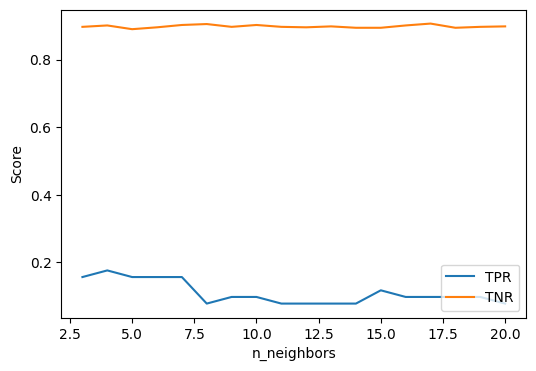

In [7]:
import pandas as pd
results = []
for n in range(3, 21):
    lof_n = LocalOutlierFactor(
        n_neighbors=n,
        contamination=0.10,    # keep contamination fixed at 0.10
        novelty=True
    )
    lof_n.fit(X_train_scaled)
    raw = lof_n.predict(X_test_scaled)
    y_pred_n = np.where(raw == -1, 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_n).ravel()
    TPR = tp / (tp + fn)
    TNR = tn / (tn + fp)
    results.append((n, TPR, TNR))
lof_df = pd.DataFrame(results, columns=['n_neighbors','TPR','TNR'])
# Plot
plt.figure(figsize=(6,4))
plt.plot(lof_df['n_neighbors'], lof_df['TPR'], label='TPR')
plt.plot(lof_df['n_neighbors'], lof_df['TNR'], label='TNR')
plt.xlabel('n_neighbors')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.show()
#We see that TPR and TNR are high around 3 neighbors. 


#### Task 2
##### Tune the contamination and find the optimal contamination parameter for the LOF model.
##### Plot the TPR and TNR for the all the contamination values used.
##### Find the optimal contamination parameter from the plot.
#### Result:


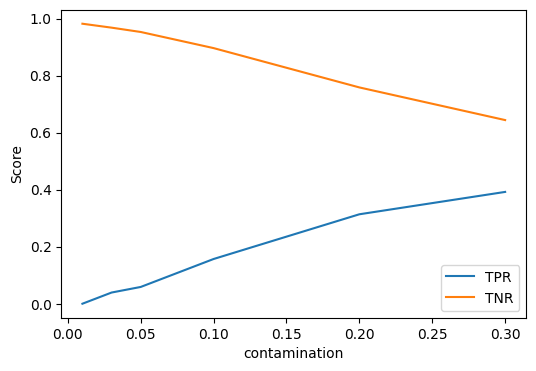

In [8]:
cont_vals = [0.01, 0.03, 0.05, 0.1, 0.2, 0.3]
results = []
for c in cont_vals:
    lof_c = LocalOutlierFactor(
        n_neighbors=3,
        contamination=c,
        novelty=True
    )
    lof_c.fit(X_train_scaled)
    raw = lof_c.predict(X_test_scaled)
    y_pred_c = np.where(raw == -1, 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_c).ravel()
    TPR = tp / (tp + fn)
    TNR = tn / (tn + fp)
    results.append((c, TPR, TNR))
cont_df = pd.DataFrame(results, columns=['contamination','TPR','TNR'])
# Plot
plt.figure(figsize=(6,4))
plt.plot(cont_df['contamination'], cont_df['TPR'], label='TPR')
plt.plot(cont_df['contamination'], cont_df['TNR'], label='TNR')
plt.xlabel('contamination')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.show()
#We see that both TPR and TNR are high around 0.2.


#### Task 3
##### Fit the LOF model with the optimal parameters
##### Evaluate this model by finding the TPR and TNR on hazard test dataset
##### Load the `ex_performance_anomalies.sav` pickle file from the data folder and the scores of the LOF model
#### Result:


In [9]:
lof_opt = LocalOutlierFactor(
    n_neighbors=3,
    contamination=0.2,
    novelty=True
)
lof_opt.fit(X_train_scaled)
raw_opt = lof_opt.predict(X_test_scaled)
y_opt  = np.where(raw_opt == -1, 1, 0)
tn, fp, fn, tp = confusion_matrix(y_test, y_opt).ravel()
non_hazard_eval = tn / (tn + fp)
print(non_hazard_eval)
hazard_eval = tp / (tp + fn)
print(hazard_eval)
performance_df_ex = pickle.load(open(str(data_dir) + '/ex_performance_anomalies.sav',"rb"))
s = pd.Series(['LOF', hazard_eval, non_hazard_eval], index=['model_name', 'TPR', 'TNR'])
performance_df_ex = pd.concat([performance_df_ex, s.to_frame().T], ignore_index=True)
performance_df_ex


0.7586206896551724
0.3137254901960784


model_name       TPR       TNR
0  DecisionTree_baseline  0.148148  0.952909
1                  SMOTE  0.296296  0.879501
2                    LOF  0.313725  0.758621

#### Task 4
##### Save both the updated performance_df_ex for downstream modules:
#### Result:


In [10]:
pickle.dump(performance_df_ex, open(f"{data_dir}/ex_performance_anomalies.sav", "wb"))


## OUTLIER DETECTION DAY 2/OUTLIER DETECTION PART 4 EXERCISE ANSWERS ##
#### Exercise 3 ####
#### Task 1
##### Import the required packages
##### Set the working directory to data directory
##### Print the working directory and the plot directory
#### Result:


In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
# Set 'main_dir' to location of the project folder
from pathlib import Path 
home_dir = Path(".").resolve()
main_dir = home_dir.parent
print(main_dir)
data_dir = str(main_dir) + "/data"
print(data_dir)


/Users/swaroopnc/Downloads/SkillAnamoly2025
/Users/swaroopnc/Downloads/SkillAnamoly2025/data


##### Task 2
##### Load pickled files from the previous exercises `ex_performance_anomalies.sav` as `performance_df_ex`,
#### Result:


In [12]:
performance_df_ex = pickle.load(open(f"{data_dir}/ex_performance_anomalies.sav","rb"))


#### Task 3
##### Load `PJM_Load_hourly.csv` dataset and print the head. Save as `pjm_load`.
##### Convert `Datatime` variable from type `object` to `datetime`. Check its datatype after type-conversion
##### Filter the data to include values post year 2000
##### Visualize the timeseries data using a lineplot
#### Result:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32896 entries, 0 to 32895
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Datetime     32896 non-null  datetime64[ns]
 1   PJM_Load_MW  32896 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 514.1 KB


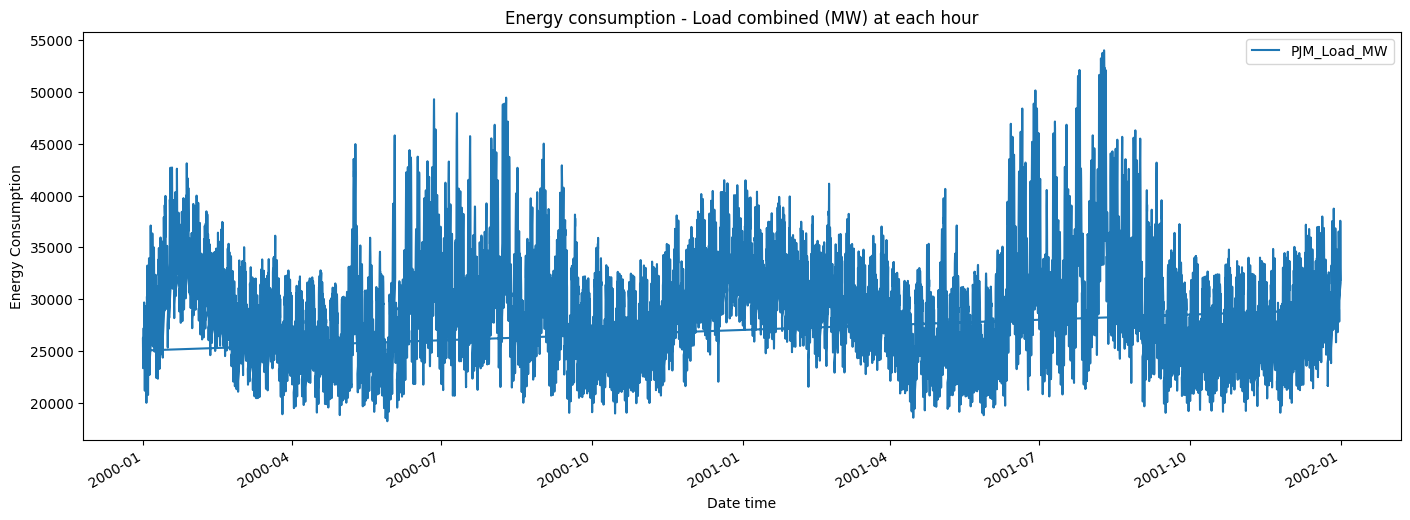

In [13]:
pjm_load = pd.read_csv(str(data_dir)+"/PJM_Load_hourly.csv")
pjm_load.head()
pjm_load['Datetime'] = pd.to_datetime(pjm_load['Datetime'])
pjm_load.info()
pjm_load = pjm_load[pjm_load['Datetime'] > '2000-01-01 00:00:00']
pjm_load.plot(x='Datetime', y='PJM_Load_MW', figsize=(17,6))
plt.xlabel('Date time')
plt.ylabel('Energy Consumption')
plt.title('Energy consumption - Load combined (MW) at each hour')
plt.show()


#### Task 4
##### Fit the LOF model with `n_neighbors: 100` , `contamination: 0.01`  and `novelty: False`
##### Predict for anomalies for the variable `PJM_Load_MW` and save the results in the pjm_load dataframe
##### Visualize the detected anomalies
#### Result:


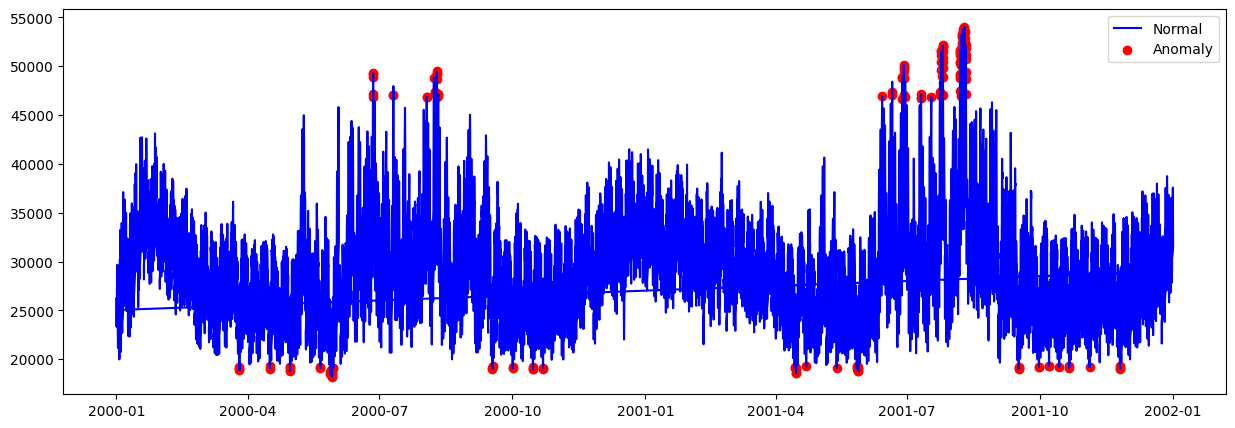

In [14]:
lof_energy_model = LocalOutlierFactor(n_neighbors = 100, contamination = 0.01, novelty = False)
lof_energy_model.fit(pd.DataFrame(pjm_load['PJM_Load_MW']))
pjm_load['anomaly'] = lof_energy_model.fit_predict(pd.DataFrame(pjm_load['PJM_Load_MW']))
fig, ax = plt.subplots(figsize=(15,5))
a = pjm_load.loc[pjm_load['anomaly'] == -1, ['Datetime', 'PJM_Load_MW']] #anomaly
ax.plot(pjm_load['Datetime'], pjm_load['PJM_Load_MW'], color='blue', label = 'Normal')
ax.scatter(a['Datetime'],a['PJM_Load_MW'], color='red', label = 'Anomaly')
plt.legend()
plt.show()


#### Task 5
##### Create variable `lof_upper_anomalies` that has the upper range of anomalies detected using the 75% quantile threshold
##### Create variable `lof_lower_anomalies` that has the lower range of anomalies detected using the 25% quantile threshold
##### Visualize `lof_upper_anomalies` and `lof_lower_anomalies`
#### Result:


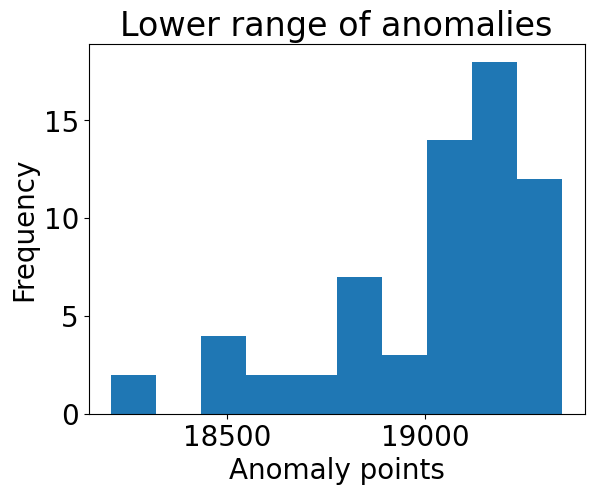

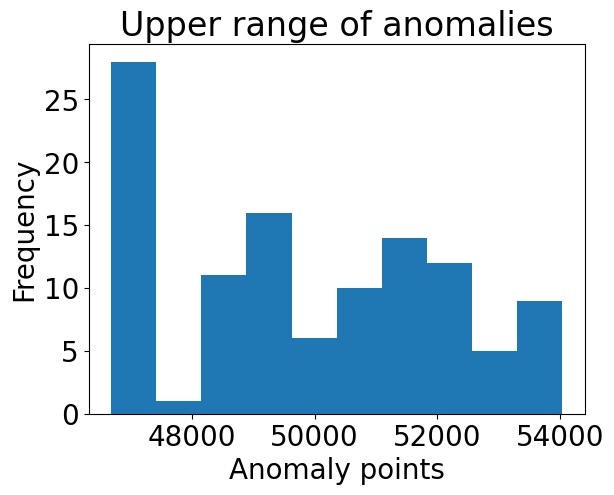

In [15]:
lower_threshold = pjm_load['PJM_Load_MW'].quantile(0.25)
upper_threshold = pjm_load['PJM_Load_MW'].quantile(0.75)
lof_anomalies = pjm_load[pjm_load['anomaly'] == -1]
# Upper range of anomalies
lof_upper_anomalies = lof_anomalies[lof_anomalies['PJM_Load_MW'] > upper_threshold]['PJM_Load_MW']
# Lower range of anomalies
lof_lower_anomalies = lof_anomalies[lof_anomalies['PJM_Load_MW'] < lower_threshold]['PJM_Load_MW']
plt.rcParams.update({'font.size': 20})
plt.hist(lof_lower_anomalies)
plt.xlabel("Anomaly points")
plt.ylabel("Frequency")
plt.title("Lower range of anomalies")
plt.show()
plt.hist(lof_upper_anomalies)
plt.xlabel("Anomaly points")
plt.ylabel("Frequency")
plt.title("Upper range of anomalies")
plt.show()


#### Exercise 4 ####
#### Task 1
##### Fit an isolation forest with 100 estimators and contamination: 0.1
#### Result:


In [16]:
iforest = IsolationForest(n_estimators=100, contamination=0.1)
# model fitting on the scaled inliers
iforest.fit(X_train_scaled)


IsolationForest(contamination=0.1)

#### Task 2 
##### Predict on the scaled hazard test set and map +1→0 (normal), –1→1 (anomaly)
#### Result:


In [17]:
raw_pred = iforest.predict(X_test_scaled)
hazard_pred = np.where(raw_pred == 1, 0, 1)


#### Task 3
##### Evaluate the model using TPR and TNR, then append to `performance_df_ex`


In [18]:
tn, fp, fn, tp = confusion_matrix(y_test, hazard_pred).ravel()
TNR = tn / (tn + fp)
TPR = tp / (tp + fn)
print("TNR:", TNR)
print("TPR:", TPR)
# append the new row
s = pd.Series(
    ['Isolation Forest', TPR, TNR],
    index=['model_name','TPR','TNR']
)
performance_df_ex = pd.concat([performance_df_ex, s.to_frame().T], ignore_index=True)
performance_df_ex


TNR: 0.926896551724138
TPR: 0.3333333333333333


model_name       TPR       TNR
0  DecisionTree_baseline  0.148148  0.952909
1                  SMOTE  0.296296  0.879501
2                    LOF  0.313725  0.758621
3       Isolation Forest  0.333333  0.926897

#### Exercise 5 ####
#### Task 1
##### Fit an isolation forest with 100 estimators and contamination: 0.01 on `pjm_load` time series data
##### Predict for anomalies on `PJM_Load_MW` variable and save the results as a column in the pjm_load dataframe
##### Visualize the detected anomalies
#### Result:


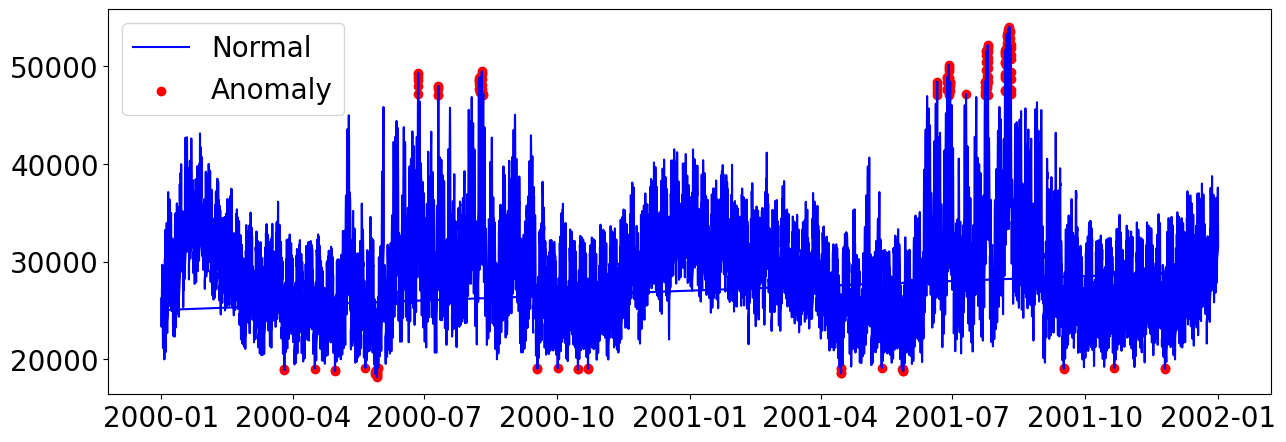

In [19]:
isolation_energy = IsolationForest(n_estimators=100, contamination = 0.01)
# model fitting
isolation_energy.fit(pd.DataFrame(pjm_load['PJM_Load_MW']))
pjm_load['anomaly'] = isolation_energy.predict(pd.DataFrame(pjm_load['PJM_Load_MW']))
# visualization
fig, ax = plt.subplots(figsize=(15,5))
a = pjm_load.loc[pjm_load['anomaly'] == -1, ['Datetime', 'PJM_Load_MW']] #anomaly
ax.plot(pjm_load['Datetime'], pjm_load['PJM_Load_MW'], color='blue', label = 'Normal')
ax.scatter(a['Datetime'],a['PJM_Load_MW'], color='red', label = 'Anomaly')
plt.legend()
plt.show()


#### Task 2
##### Create variable `if_upper_anomalies` that has the upper range of anomalies detected using the 75% quantile threshold
##### Create variable `if_lower_anomalies` that has the lower range of anomalies detected using the 25% quantile threshold
##### Visualize `if_upper_anomalies` and `if_lower_anomalies`
#### Result:


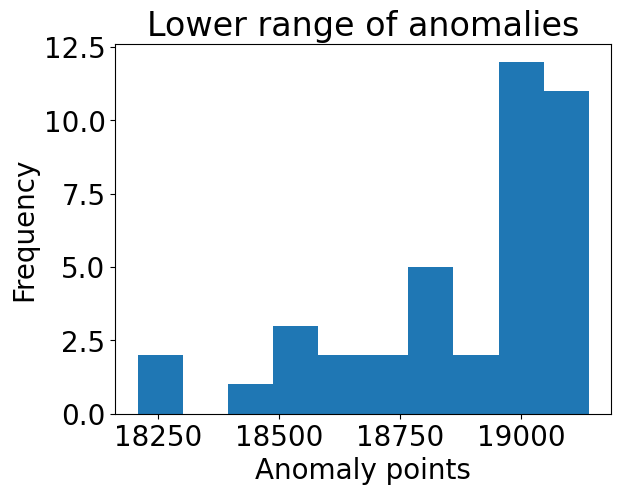

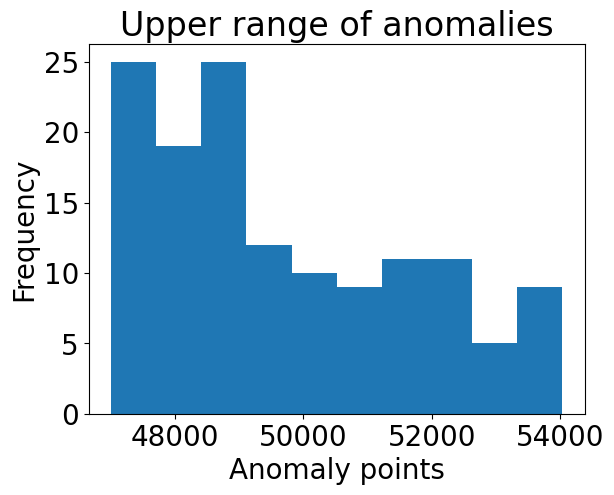

In [20]:
# visualization
lower_threshold = pjm_load['PJM_Load_MW'].quantile(0.25)
upper_threshold = pjm_load['PJM_Load_MW'].quantile(0.75)
if_anomalies = pjm_load[pjm_load['anomaly'] == -1]
if_upper_anomalies = if_anomalies[if_anomalies['PJM_Load_MW'] > upper_threshold]['PJM_Load_MW']
if_lower_anomalies = if_anomalies[if_anomalies['PJM_Load_MW'] < lower_threshold]['PJM_Load_MW']
plt.hist(if_lower_anomalies)
plt.xlabel("Anomaly points")
plt.ylabel("Frequency")
plt.title("Lower range of anomalies")
plt.show()
plt.hist(if_upper_anomalies)
plt.xlabel("Anomaly points")
plt.ylabel("Frequency")
plt.title("Upper range of anomalies")
plt.show()


#### Task 3
##### Compare the anomalies detected from LOF and Isolation Forest
##### Create a comparison plot for the lower range of anomalies
##### Create a comparison plot for the upper range of anomalies
#### Result:


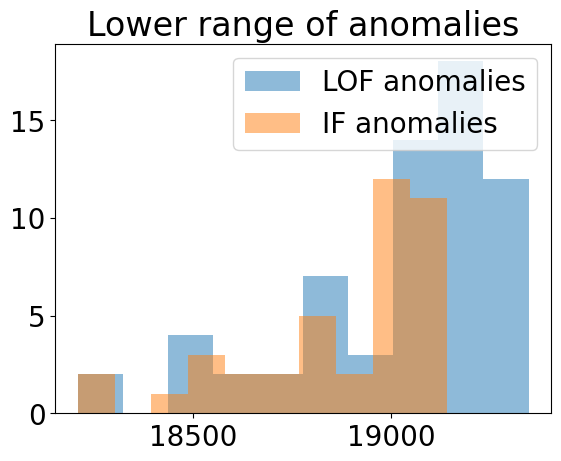

In [21]:
plt.hist(lof_upper_anomalies,alpha = 0.5,label='LOF anomalies')
plt.hist(if_upper_anomalies,alpha = 0.5,label='IF anomalies')
plt.title('Upper range of anomalies')
plt.legend(loc='upper right')
plt.show()
plt.hist(lof_lower_anomalies,alpha = 0.5,label='LOF anomalies')
plt.hist(if_lower_anomalies,alpha = 0.5,label='IF anomalies')
plt.title('Lower range of anomalies')
plt.legend(loc='upper right')
plt.show()


#### Task 4
##### Save the `performance_df_ex` as a pickle file `ex_performance_anomalies.sav`
#### Result:


In [22]:
pickle.dump(performance_df_ex, open(str(data_dir) + "/ex_performance_anomalies.sav","wb" ))
